In [11]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import defaultdict
import json
from itertools import chain, tee
import requests
import os
from run_db import CachingRunInfo

In [12]:
with open("problems_since_2015.json") as problems_io:
    problems = json.load(problems_io)

In [13]:
run_info = CachingRunInfo()

In [14]:
meta_fields = ("tck", "programVersion")
def get_runs_pair_metainfo_diff(pair):
    return [run_info[pair[0]][field] != run_info[pair[1]][field] for
            field in meta_fields]

from scipy.spatial.distance import canberra

numeric_meta_fields = ("avLumi", "betaStar", "veloOpening", "avPhysDeadTime")
def get_runs_pair_numberic_metainfo_diff(pair):
    return [canberra(float(run_info[pair[0]][field]),
                     float(run_info[pair[1]][field]))
            for field in numeric_meta_fields]

In [15]:
# https://docs.python.org/2/library/itertools.html
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [16]:
from data_ops import connect_to_mongo
from config import DB_PORT, DB_HOST, RES_DB_NAME
cli = connect_to_mongo(DB_PORT, DB_HOST)

In [17]:
def get_score_or_none(pair):
    collection_name = "%d_%d" % tuple(sorted(pair))
    comparisons = list(cli[RES_DB_NAME][collection_name].find())
    if len(comparisons) == 0:
        return (numpy.nan, numpy.nan)    
    results = comparisons[-1]["results"][-1]
    return (results[0], results[1])        

In [18]:
FIGSIZE = (8, 5)

In [19]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

/afs/cern.ch/user/n/nkazeev/miniconda3/envs/high-level-anomalies/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


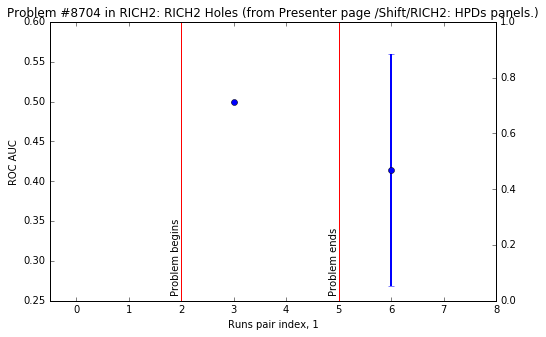

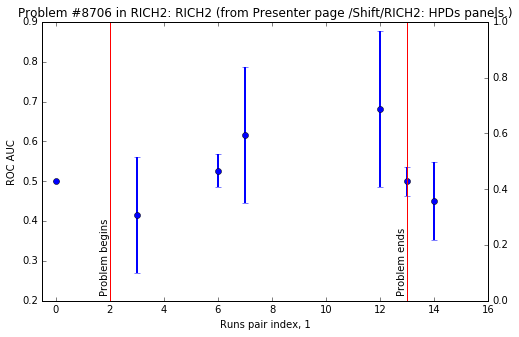

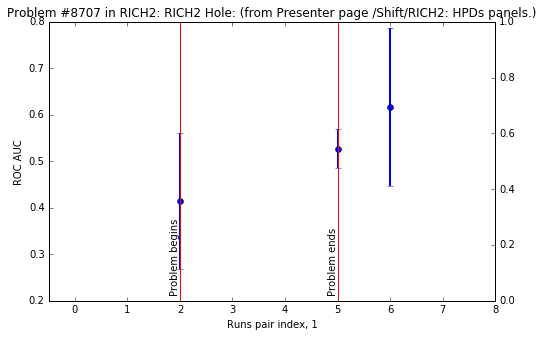

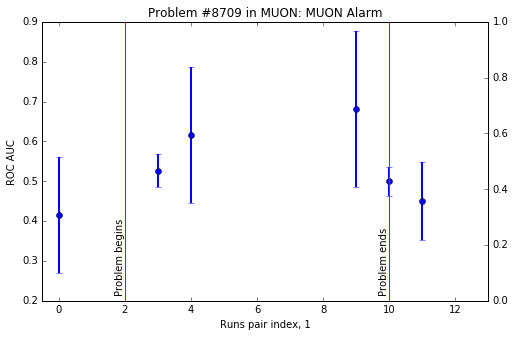

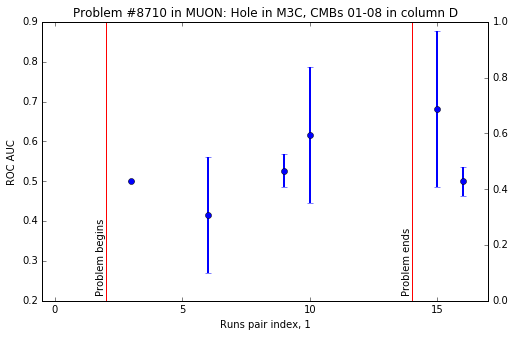

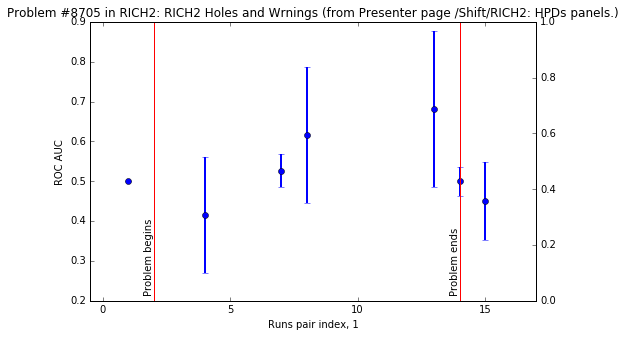

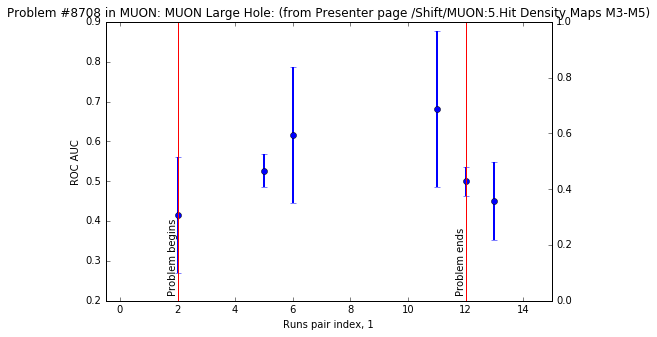

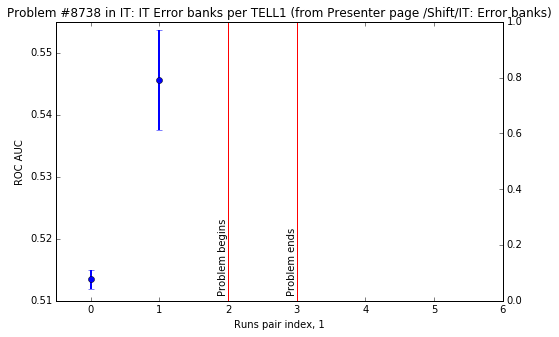

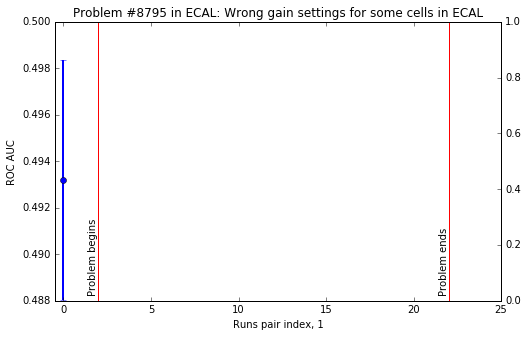

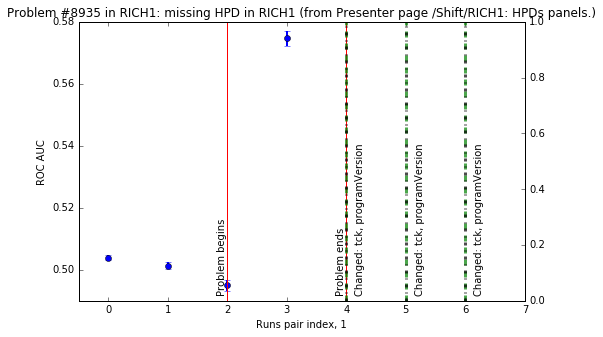

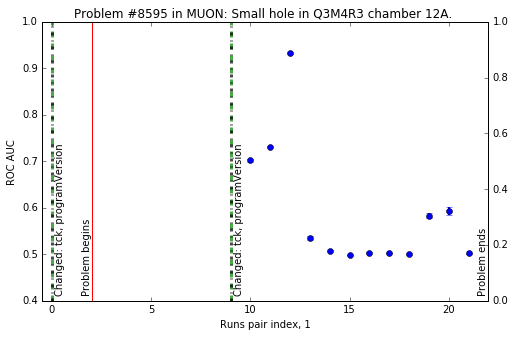

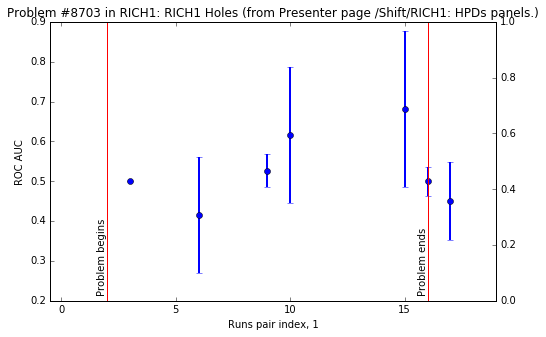

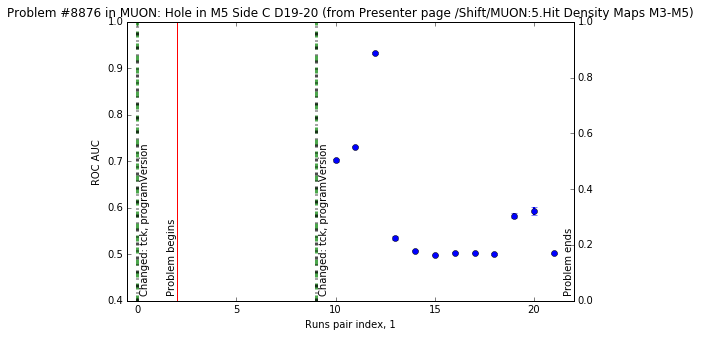

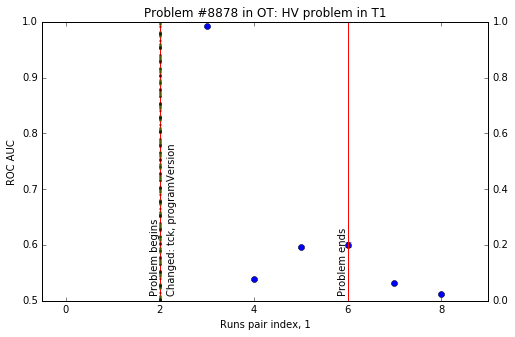

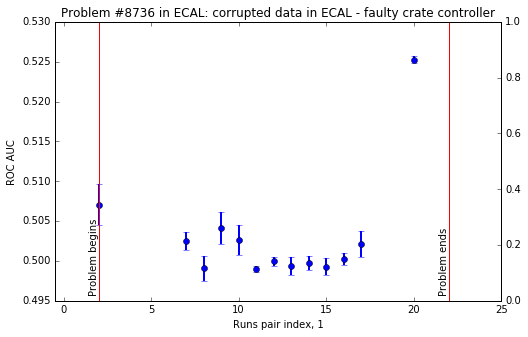

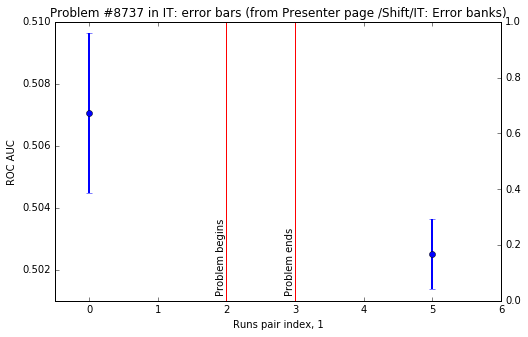

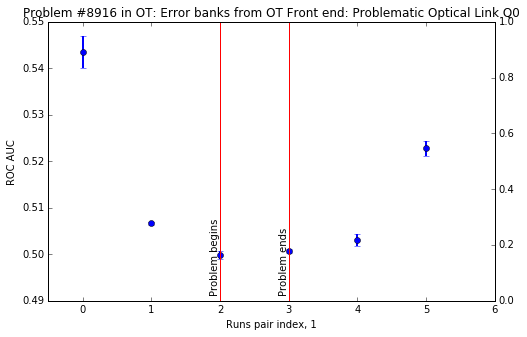

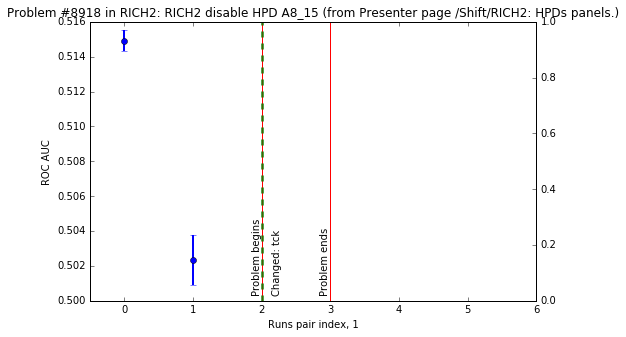

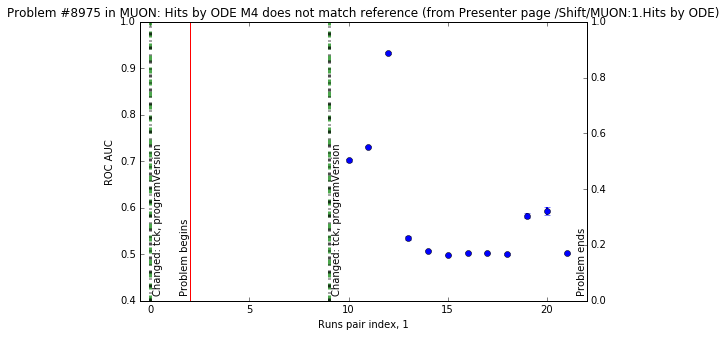

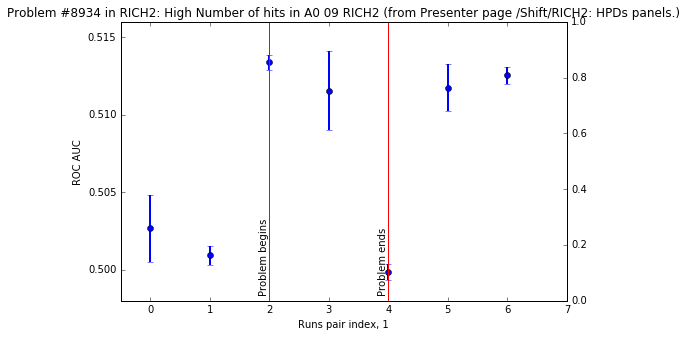

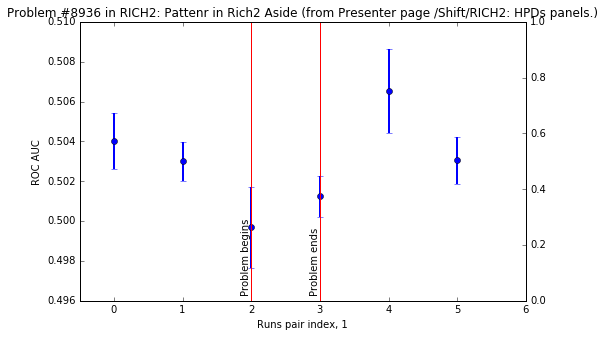

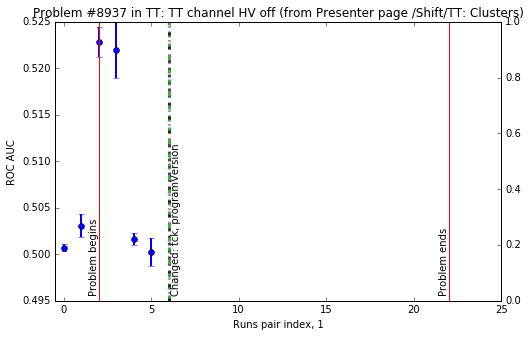

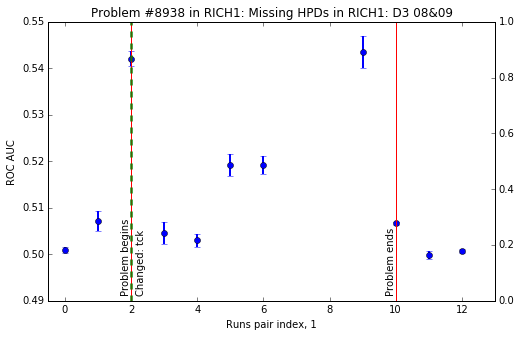

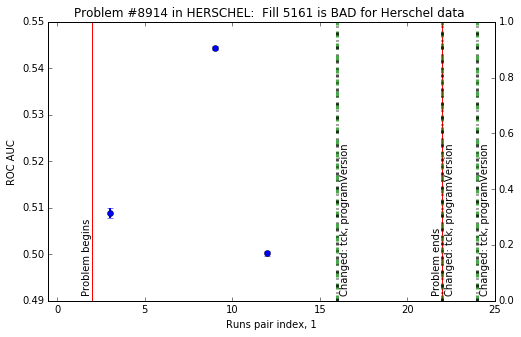

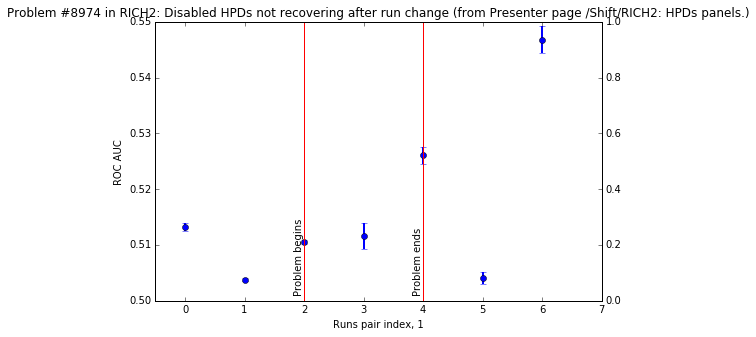

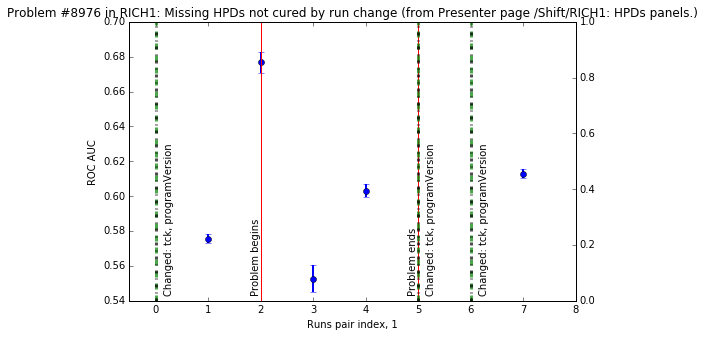

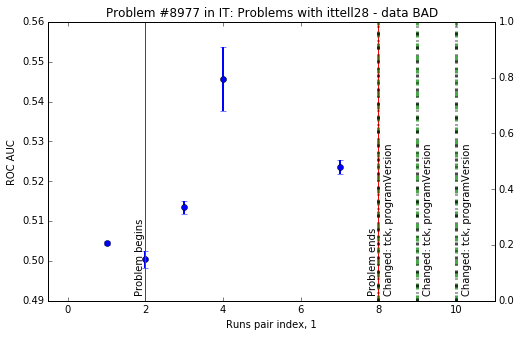

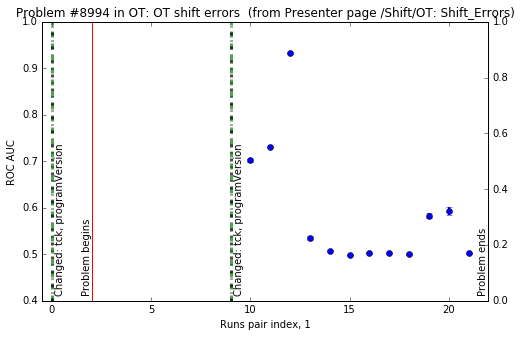

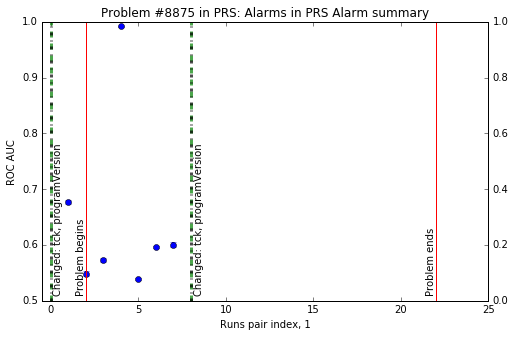

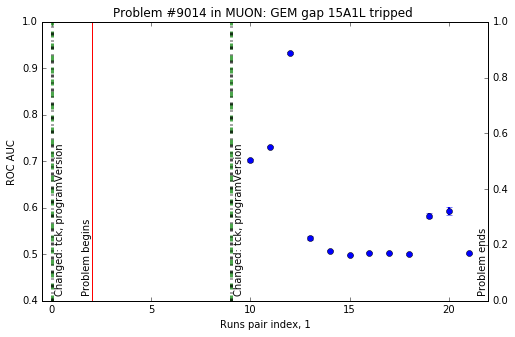

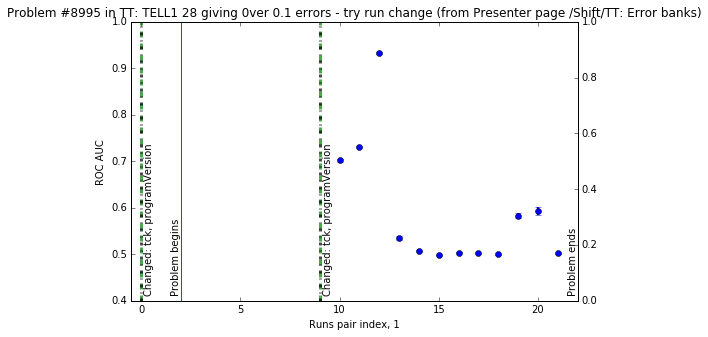

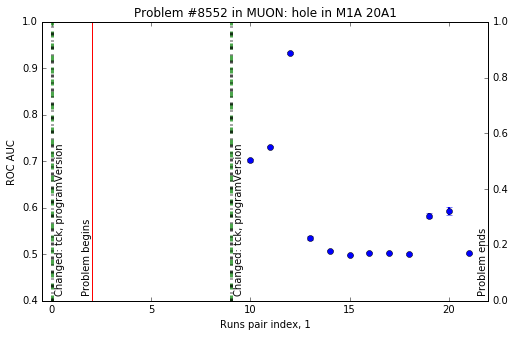

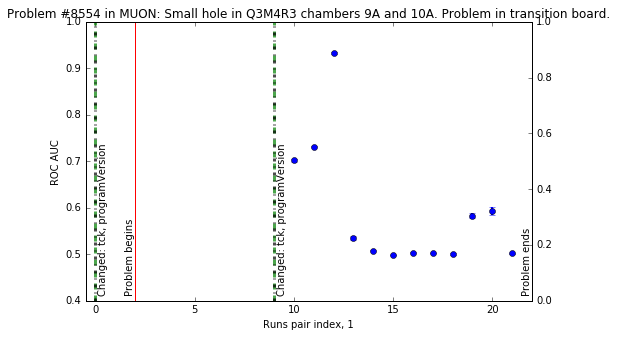

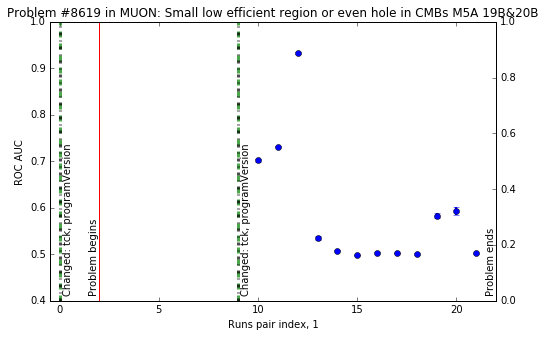

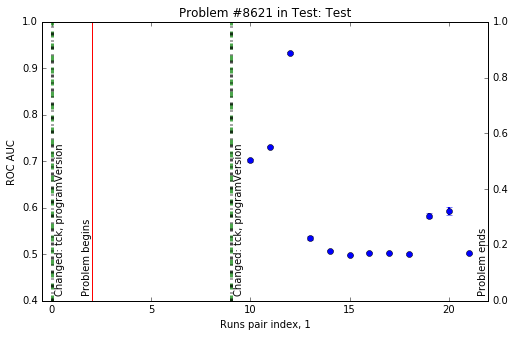

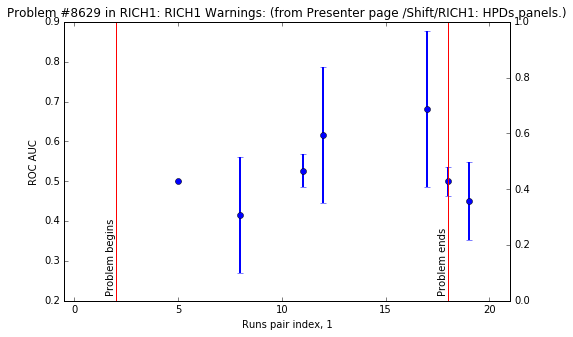

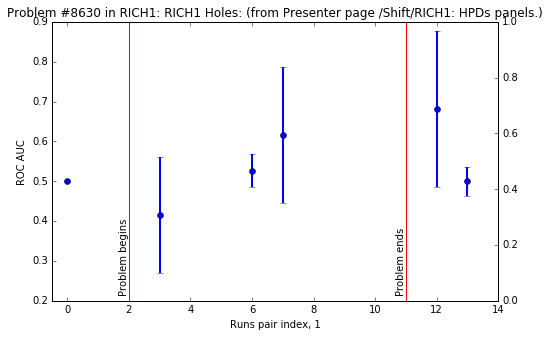

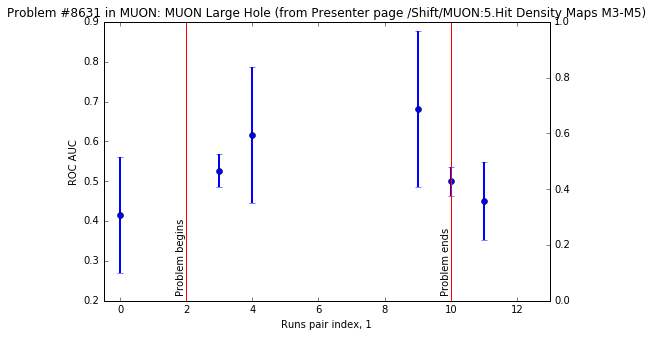

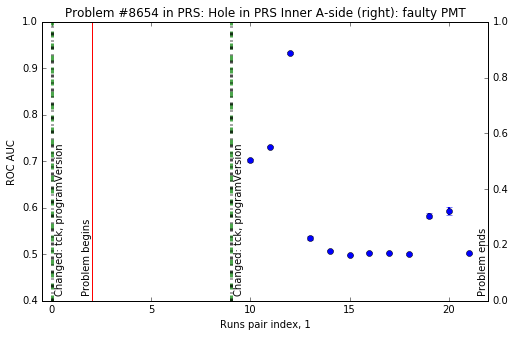

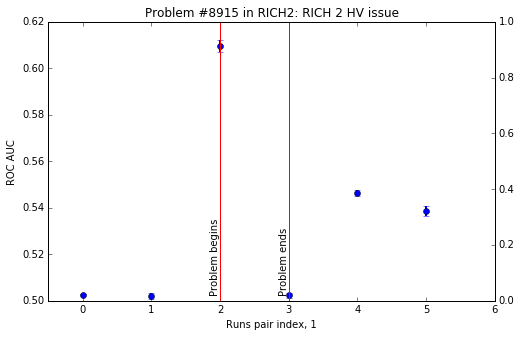

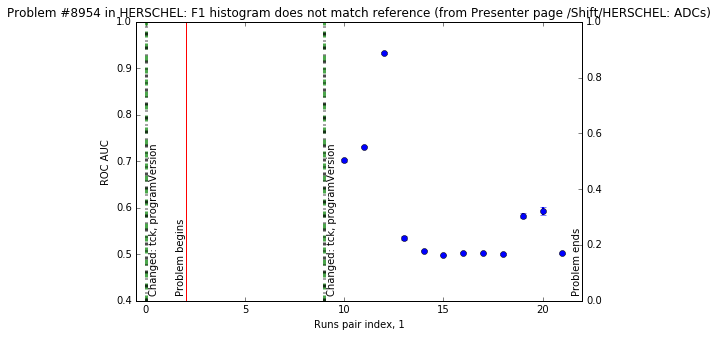

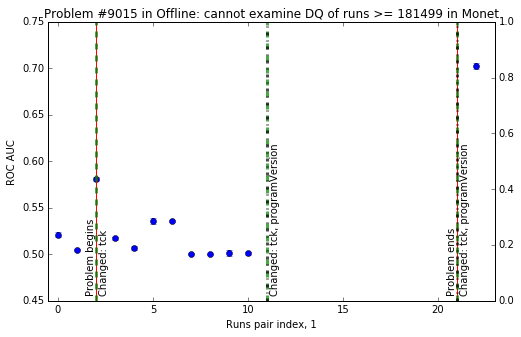

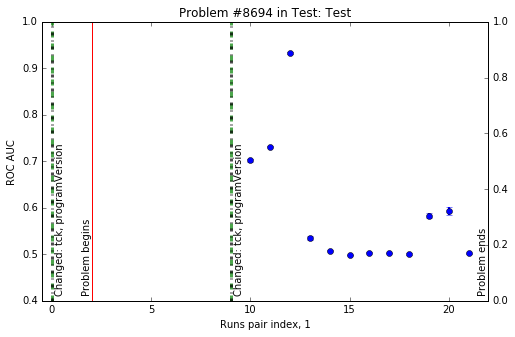

In [20]:
out_problem_scores = []
in_problem_scores = []
problem_begins_scores = []
border_scores = []
    
for problem_and_runs in problems:
    problem = problem_and_runs[0]
    runs_for_problem = problem_and_runs[1:]
    runs_pairs = list(pairwise(chain(*runs_for_problem)))
    metainfo_diff = list(map(get_runs_pair_metainfo_diff, runs_pairs))
    metainfo_stable = list(map(lambda metainfo: not any(metainfo), metainfo_diff))
    scores_pairs = list(map(get_score_or_none, runs_pairs))

    scores = numpy.array(list(map(itemgetter(0), scores_pairs)))
    scores_std = list(map(itemgetter(1), scores_pairs))
    
    problem_begins_index = len(runs_for_problem[0]) - 1
    problem_ends_index = len(runs_for_problem[0]) + len(runs_for_problem[1]) - 1
    
    def append_valid_runs(min_, max_):
        return map(itemgetter(0), filter(lambda x: (not numpy.isnan(x[0])) and x[1],
                                                       zip(scores[min_: max_], metainfo_stable[min_: max_])))
    out_problem_scores.extend(append_valid_runs(0, problem_begins_index))
    out_problem_scores.extend(append_valid_runs(problem_ends_index + 1, len(scores)))
    in_problem_scores.extend(append_valid_runs(problem_begins_index + 1, problem_ends_index))
    problem_begins_scores.extend(append_valid_runs(problem_begins_index, problem_begins_index + 1))
    
    border_scores.extend(append_valid_runs(problem_begins_index, problem_begins_index + 1))
    border_scores.extend(append_valid_runs(problem_ends_index, problem_ends_index + 1))
    if numpy.isnan(scores).all():
        continue
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.errorbar(numpy.arange(len(scores)), scores, scores_std, fmt="o", lw=2)
    ax_meta = ax.twinx()
    ax_meta.axvline(problem_begins_index, c="r")
    ax_meta.text(problem_begins_index, 2e-2, "Problem begins", rotation=90, verticalalignment="bottom",
                 horizontalalignment="right")
    ax_meta.axvline(problem_ends_index, c="r")
    ax_meta.text(problem_ends_index, 2e-2, "Problem ends", rotation=90, verticalalignment="bottom",
                 horizontalalignment="right")
    labels_for_index = defaultdict(list)
    for change_index, change_field in zip(*numpy.nonzero(metainfo_diff)):
        color = ("green", "black", "pink")[change_field]
        ls = ("--", "-.", "-")[change_field]
        ax_meta.axvline(change_index, c=color, ls=ls, lw=3, alpha=0.7)
        labels_for_index[change_index].append(meta_fields[change_field])
    for change_index, labels in labels_for_index.items():
        ax_meta.text(change_index+0.15, 2e-2, "Changed: " + ", ".join(labels), rotation=90,
                     verticalalignment="bottom", horizontalalignment="left")
    ax.set_xlim(-0.5, len(runs_pairs))
    ax.set_xlabel("Runs pair index, 1")
    ax.set_ylabel("ROC AUC")
    
    ax.set_title("Problem #%s in %s: %s" % (problem["id"], problem["system"], problem["title"]))
    
    plot_name = "%s-%s.pdf" % (problem["id"], problem["system"])
    fig.savefig(os.path.join("plots", plot_name))

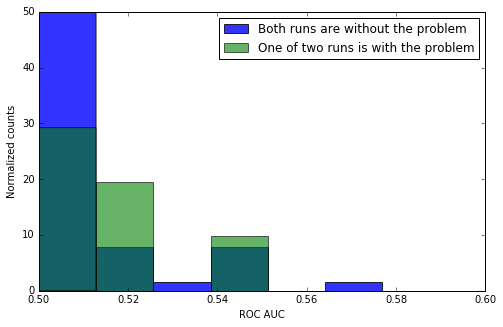

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE)
bins = numpy.linspace(0.5, 1, num=40)
ax.hist(out_problem_scores, bins=bins, normed=True, alpha=0.8, label="Both runs are without the problem");
ax.hist(problem_begins_scores, alpha=0.6, bins=bins, normed=True, label="One of two runs is with the problem");
ax.set_xlim(0.5, 0.6)
ax.set_xlabel("ROC AUC")
ax.set_ylabel("Normalized counts")
ax.legend();

In [22]:
from sklearn.metrics import precision_recall_curve

In [23]:
precision, recall, _ = precision_recall_curve(numpy.concatenate((
        numpy.zeros(len(out_problem_scores)), numpy.ones(len(problem_begins_scores)))),
        numpy.concatenate((out_problem_scores, problem_begins_scores)))

62 13


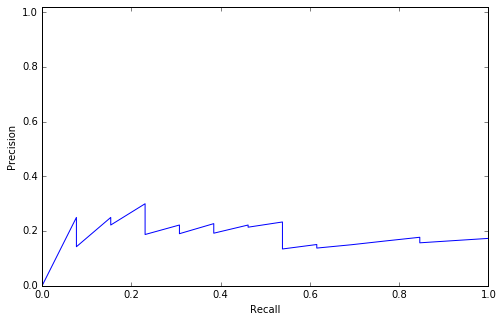

In [24]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(recall, precision);
ax.set_ylim(0, 1.02)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision");
fig.savefig("precision_recall.pdf", bbox="tight")
print(len(out_problem_scores), len(problem_begins_scores))

In [25]:
from IPython.display import FileLink
FileLink("precision_recall.pdf")

/afs/cern.ch/user/n/nkazeev/high-level-anomalies/precision_recall.pdf